Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime
import datetime as dt
import copy
from efficientnet_pytorch import EfficientNet
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

In [2]:
from data_setup import copy_images_to_folders
from image_check import imshow
from model import CustomEfficientNetB0, validate_model, train_model, plot_metrics, visualize_model
from uncertainty_metrics import calculate_risks, process_labels, calculate_and_append_risks, calculate_and_append_risks_by_class, calculate_softmax_uncertainties, calculate_top2_softmax_uncertainties, calculate_random_uncertainties, calculate_mc_dropout_uncertainties_by_sample, calculate_mc_dropout_uncertainties_by_class, calculate_variance_uncertainties, calculate_variational_ratio_uncertainties, calculate_entropy_uncertainties, calculate_predictive_entropy_uncertainties, calculate_mutual_information_uncertainties, smooth_calcs, calculate_aurc, plot_risk_coverage

In [3]:
# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

# set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Sort data into folders based on class

In [4]:
csv_path = 'data/ISIC_2019_Training_GroundTruth.csv'
image_folder = 'data/ISIC_2019_Resized'
output_folder = 'data/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)

print("done")

done


Split data into training, validation and test

In [5]:
# declare variables for model creation
input_folder = 'data/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = 'data/data_subset'  # The desired output folder for "training" and "validation" folders
sample_limit=239 #None or a number up to 12875
train_ratio=0.6
val_ratio=0.2
test_ratio=0.2

if train_ratio+val_ratio+test_ratio != 1:
    print("invalid data ratios")

set_batch_size=64

#sample numbers by class copied here for reference
#MEL	NV	    BCC	    AK	 BKL	DF	VASC  SCC	UNK
#4522	12875	3323	867	 2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

print("done")

done


In [6]:
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

In [7]:
# Remove existing "training" and "validation" folders if they exist
shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)
shutil.rmtree(test_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

print("done")

done


In [8]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]
        
        # Limit the number of samples if sample_limit is provided
        if sample_limit is not None:
            images = images[:sample_limit]

        # Randomly shuffle the list of images
        np.random.seed(42)
        np.random.shuffle(images)

        # Calculate the number of samples for training and validation
        class_size = len(images)
        num_training_samples = int(class_size * train_ratio)
        num_val_samples = int(class_size * val_ratio)
        num_test_samples = int(class_size * test_ratio)

        # Create the class subfolders within the output folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        class_folder_test = os.path.join(test_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)
        os.makedirs(class_folder_test, exist_ok=True)

        # Copy images to the training folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)
        # Copy images to the validation folder
        for image_name in images[num_training_samples:num_training_samples + num_val_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)
        # Copy images to the test folder
        for image_name in images[num_training_samples + num_val_samples:]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_test)

print("done")

done


In [9]:
#remove unknown folder as no samples
shutil.rmtree("data/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/val/UNK", ignore_errors=True)
shutil.rmtree("data/data_subset/test/UNK", ignore_errors=True)

In [10]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [11]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

#print checks to see if the values are the same - if yes then can remove the assignment here
class_names = image_datasets['train'].classes
num_classes = len(class_names)
print(f"file: ", class_names)

file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


show sample images

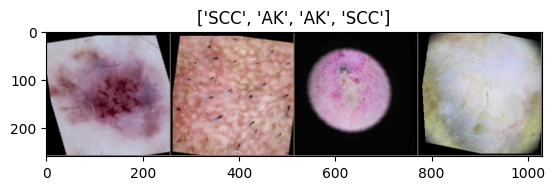

In [12]:
# Specify the number of images to display
num_images = 4

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Select a subset of images
inputs_subset = inputs[:num_images]
classes_subset = classes[:num_images]

# Make a grid from the subset
out = torchvision.utils.make_grid(inputs_subset)

imshow(out, title=[class_names[x] for x in classes_subset])

temporary fix for efficientnet weights issue

In [13]:
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_epoch = 0

# Initialize the custom model with dropout
model_ft = CustomEfficientNetB0(num_classes=num_classes, dropout_prob=0.3)

# Move the model to the specified device (e.g., GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function (cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# Use the Adam optimizer for training
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Define a learning rate scheduler to decay the learning rate
# by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [15]:
train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, train_losses, train_accuracies, val_losses, val_accuracies, best_epoch, num_epochs=5, num_val_mc_samples=50, loss_weight=1, num_classes=num_classes)

Epoch 1/5 - 2024-03-06 12:01:16
----------
Train Loss: 0.1966, Train Acc: 0.4353
Val Loss: 0.1699, Val Acc: 0.4894

Epoch 2/5 - 2024-03-06 12:02:24
----------
Train Loss: 0.1193, Train Acc: 0.6591
Val Loss: 0.1617, Val Acc: 0.5346

Epoch 3/5 - 2024-03-06 12:03:32
----------
Train Loss: 0.0884, Train Acc: 0.7378
Val Loss: 0.2630, Val Acc: 0.4867

Epoch 4/5 - 2024-03-06 12:04:40
----------
Train Loss: 0.0765, Train Acc: 0.7622
Val Loss: 0.1275, Val Acc: 0.6676

Epoch 5/5 - 2024-03-06 12:05:48
----------
Train Loss: 0.0591, Train Acc: 0.8234
Val Loss: 0.2139, Val Acc: 0.6064

Best combined metric: 0.5401
Loss associated with the best combined metric: 0.1275
Accuracy associated with the best combined metric: 0.6676
Epoch associated with the best model: 4


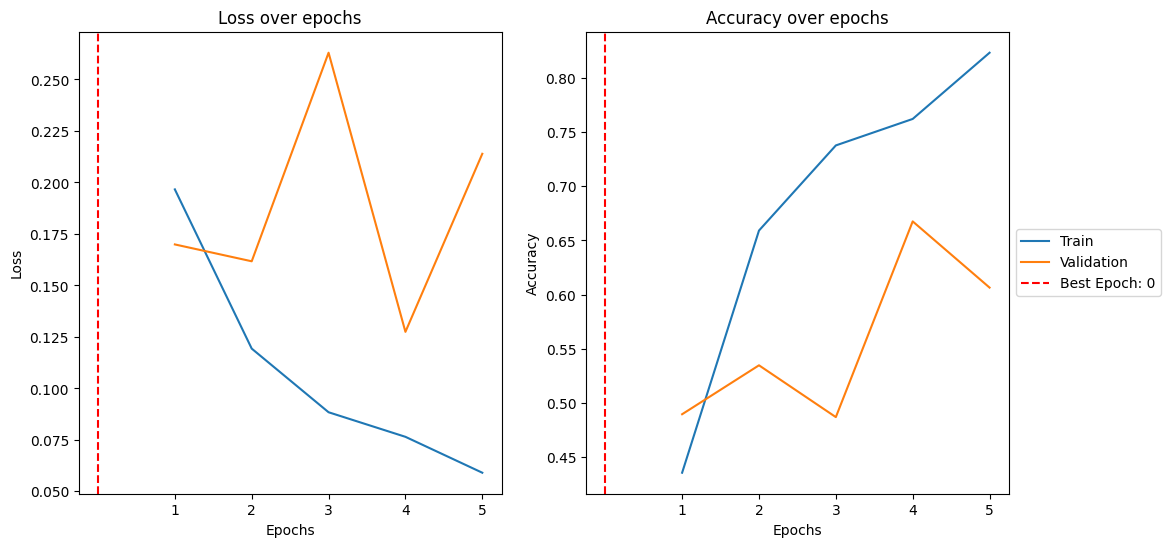

In [16]:
plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, best_epoch)

In [17]:
# Save the trained model
torch.save(model_ft.state_dict(), 'data/trained_model.pth')

In [18]:
#load the saved model
model_ft.load_state_dict(torch.load('data/trained_model.pth'))

<All keys matched successfully>

visualise trained model

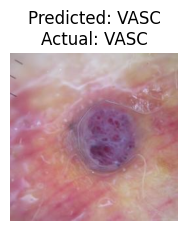

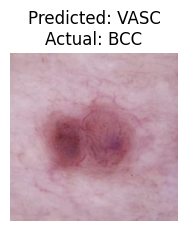

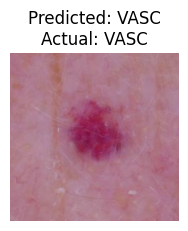

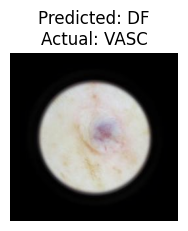

In [19]:
visualize_model(model_ft, dataloaders['val'], device, class_names, num_images=4)

In [20]:
# Lists to store results
risks_list = []
labels_list = []

risks_list_by_class = [[] for _ in range(len(class_names))]
labels_list_by_class = [[] for _ in range(len(class_names))]

print("done")

done


In [21]:
guesses_are_correct, uncertainties, sample_labels = calculate_softmax_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Softmax Response")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Softmax Response")

print("done")

done


In [22]:
guesses_are_correct, uncertainties, sample_labels = calculate_top2_softmax_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Top2 Softmax Difference")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Top2 Softmax Difference")

print("Done")

Done


In [23]:
guesses_are_correct, uncertainties, sample_labels = calculate_random_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Random Uncertainties")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Random Uncertainties")

print("Done")

Done


In [24]:
guesses_are_correct, uncertainties, sample_labels = calculate_mc_dropout_uncertainties_by_sample(model_ft, dataloaders['test'], class_names, device, num_samples=50)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "MCD By Sample")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "MCD By Sample")

print("Done")

2024-03-06 12:08:21.402040 - Batch 1/7 processed
2024-03-06 12:08:26.876711 - Batch 2/7 processed
2024-03-06 12:08:32.360745 - Batch 3/7 processed
2024-03-06 12:08:37.880646 - Batch 4/7 processed
2024-03-06 12:08:43.355150 - Batch 5/7 processed
2024-03-06 12:08:48.828775 - Batch 6/7 processed
2024-03-06 12:08:49.351209 - Batch 7/7 processed
Done


In [25]:
guesses_are_correct, uncertainties, sample_labels = calculate_mc_dropout_uncertainties_by_class(model_ft, dataloaders['test'], class_names, device, num_samples=50)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "MCD By Class")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "MCD By Class")

print("Done")

2024-03-06 12:08:57.308766 - Batch 1/7 processed
2024-03-06 12:09:02.843762 - Batch 2/7 processed
2024-03-06 12:09:08.298835 - Batch 3/7 processed
2024-03-06 12:09:13.752981 - Batch 4/7 processed
2024-03-06 12:09:19.208540 - Batch 5/7 processed
2024-03-06 12:09:24.665100 - Batch 6/7 processed
2024-03-06 12:09:25.143550 - Batch 7/7 processed
Done


In [26]:
guesses_are_correct, uncertainties, sample_labels = calculate_variance_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Variance")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Variance")

print("Done")

Done


In [27]:
guesses_are_correct, uncertainties, sample_labels = calculate_variational_ratio_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Variational Ratio")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Variational Ratio")

print("Done")

Done


In [28]:
guesses_are_correct, uncertainties, sample_labels = calculate_entropy_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Entropy")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Entropy")

print("Done")

Done


In [29]:
guesses_are_correct, uncertainties, sample_labels = calculate_predictive_entropy_uncertainties(model_ft, dataloaders['test'], class_names, device, num_samples=50)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Predictive Entropy")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Predictive Entropy")

print("Done")

2024-03-06 12:09:42.911659 - Batch 1/7 processed
2024-03-06 12:09:48.366781 - Batch 2/7 processed
2024-03-06 12:09:53.866767 - Batch 3/7 processed
2024-03-06 12:09:59.379709 - Batch 4/7 processed
2024-03-06 12:10:04.845575 - Batch 5/7 processed
2024-03-06 12:10:10.304060 - Batch 6/7 processed
2024-03-06 12:10:10.783483 - Batch 7/7 processed
Done


In [30]:
guesses_are_correct, uncertainties, sample_labels = calculate_mutual_information_uncertainties(model_ft, dataloaders['test'], class_names, device)
guesses_are_correct_by_class, uncertainties_by_class = process_labels(sample_labels, guesses_are_correct, uncertainties, class_names)
calculate_and_append_risks(risks_list, labels_list, guesses_are_correct, uncertainties, "Mutual Information")
calculate_and_append_risks_by_class(risks_list_by_class, labels_list_by_class, guesses_are_correct_by_class, uncertainties_by_class, class_names, "Mutual Information")

print("Done")

Done


In [31]:
description_list = [
    "Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.",
    "Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities",
    "Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.",
    "MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.",
    "MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.",
    "Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.",
    "Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.",
    "Entropy calculates uncertainty by measuring the entropy of softmax probabilities for each prediction.",
    "Predictive Entropy estimates uncertainty by averaging the entropy of softmax probabilities across multiple samples generated with dropout.",
    "Mutual Information computes uncertainty by measuring the mutual information between the model's softmax probabilities and a uniform distribution."
]

for description in description_list:
    print(f"- {description}")

print(
"""
- Risk = 1 - Accuracy, where Accuracy is the mean accuracy (normalised) over the samples included in the Coverage.
- Coverage is the normalised number of samples over the total samples. Coverage decreases as the most uncertain samples are removed.
- Area Under Risk Coverage (AURC) is the area under the Risk Coverage curve.

- Classes:
    - Melanoma (MEL)
    - Melanocytic nevus (NV)
    - Basal cell carcinoma (BCC)
    - Actinic keratosis (AK)
    - Benign keratosis (BKL) 
        [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
    - Dermatofibroma (DF)
    - Vascular lesion (VASC)
    - Squamous cell carcinoma (SCC)
    - None of the others (UNK)
"""
)

- Softmax Response measures the model's confidence in its predictions based on the softmax probabilities.
- Top2 Softmax Difference measures the uncertainty by calculating the difference between the top two softmax probabilities
- Random Uncertainties assigns random uncertainty values to each prediction, providing a baseline comparison for uncertainty estimation methods.
- MCD By Sample utilizes Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout.
- MCD By Class employs Monte Carlo Dropout (MCD) to estimate uncertainties by averaging predictions across multiple samples with dropout for each class.
- Variance calculates uncertainty by computing the variance of softmax probabilities across classes for each prediction.
- Variational Ratio calculates uncertainty by computing the ratio of the maximum softmax probability (mode probability) to the maximum probability among other classes for each prediction.
- Entropy calculates unc

All Classes: 392 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.1270			0.1280
MCD By Class                	0.1306			0.1314
MCD By Sample               	0.1343			0.1343
Variance                    	0.1347			0.1347
Softmax Response            	0.1349			0.1349
Predictive Entropy          	0.1359			0.1359
Top2 Softmax Difference     	0.1361			0.1361
Entropy                     	0.1363			0.1365
Variational Ratio           	0.1380			0.1380
Random Uncertainties        	0.2607			0.3192


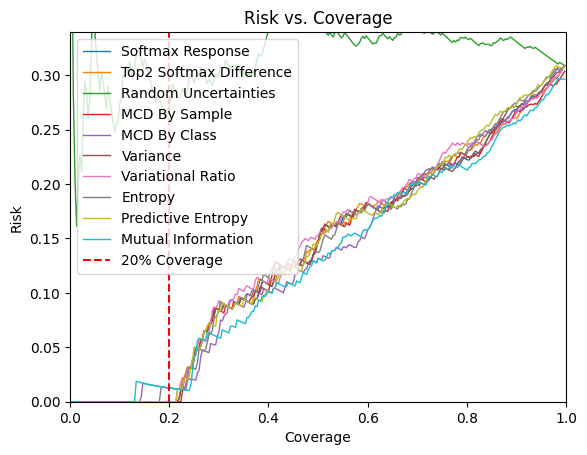

AK: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.1689			0.1935
MCD By Class                	0.1912			0.2425
Entropy                     	0.2152			0.2503
MCD By Sample               	0.2152			0.2694
Softmax Response            	0.2188			0.2752
Predictive Entropy          	0.2206			0.2776
Variance                    	0.2212			0.2791
Top2 Softmax Difference     	0.2216			0.2801
Variational Ratio           	0.2242			0.2877
Random Uncertainties        	0.2266			0.2882


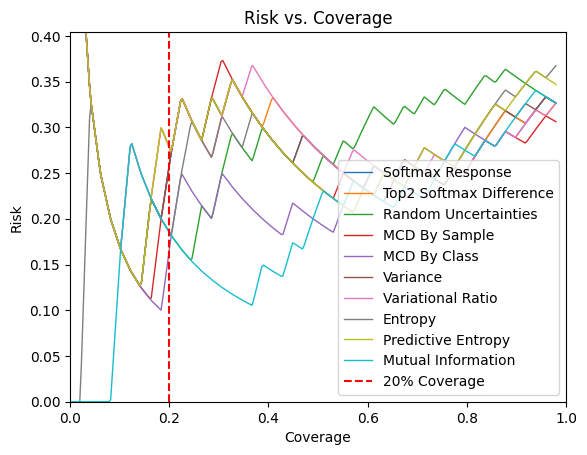


BCC: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.1531			0.1700
Variational Ratio           	0.1562			0.1720
Top2 Softmax Difference     	0.1577			0.1721
MCD By Sample               	0.1591			0.1734
Softmax Response            	0.1594			0.1749
Variance                    	0.1604			0.1752
MCD By Class                	0.1611			0.1761
Predictive Entropy          	0.1620			0.1778
Entropy                     	0.1636			0.1829
Random Uncertainties        	0.2432			0.3126


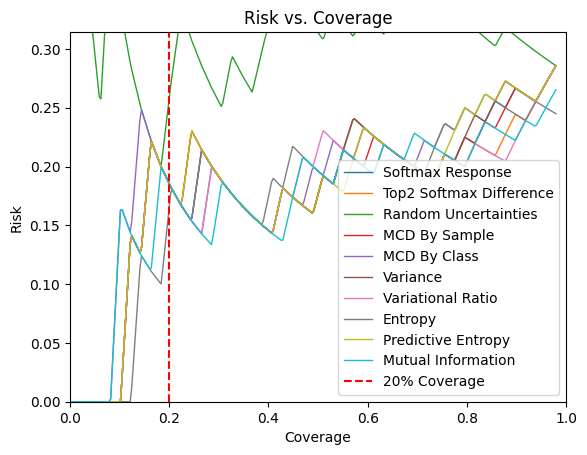


BKL: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Softmax Response            	0.0008			0.0008
Top2 Softmax Difference     	0.0008			0.0008
MCD By Sample               	0.0008			0.0008
MCD By Class                	0.0008			0.0008
Variance                    	0.0008			0.0008
Variational Ratio           	0.0008			0.0008
Entropy                     	0.0008			0.0008
Predictive Entropy          	0.0008			0.0008
Mutual Information          	0.0008			0.0008
Random Uncertainties        	0.0143			0.0143


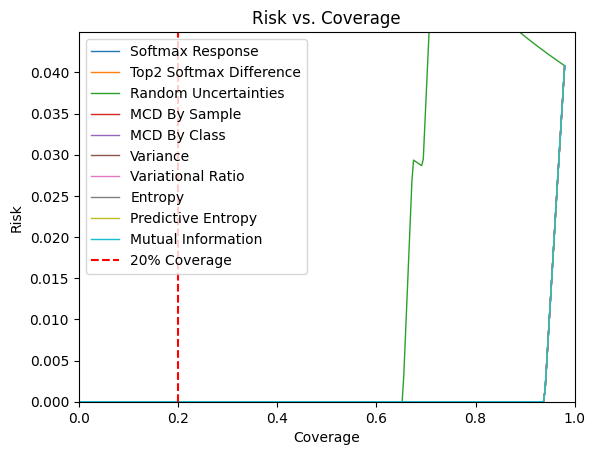


DF: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
MCD By Class                	0.0105			0.0105
Softmax Response            	0.0130			0.0130
Variance                    	0.0130			0.0130
Mutual Information          	0.0142			0.0142
Top2 Softmax Difference     	0.0143			0.0143
MCD By Sample               	0.0146			0.0146
Variational Ratio           	0.0163			0.0163
Predictive Entropy          	0.0173			0.0173
Entropy                     	0.0183			0.0183
Random Uncertainties        	0.0394			0.0394


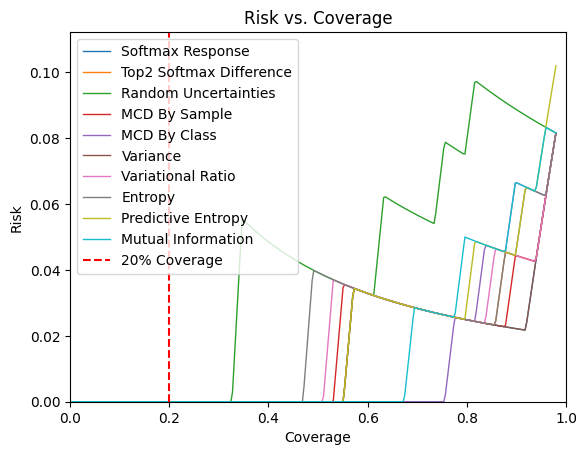


MEL: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
MCD By Class                	0.4456			0.5778
Entropy                     	0.4532			0.5849
Softmax Response            	0.4555			0.6121
Top2 Softmax Difference     	0.4560			0.6149
MCD By Sample               	0.4564			0.6160
Variational Ratio           	0.4577			0.6165
Variance                    	0.4579			0.6174
Mutual Information          	0.4643			0.6189
Predictive Entropy          	0.4703			0.6312
Random Uncertainties        	0.5652			0.7345


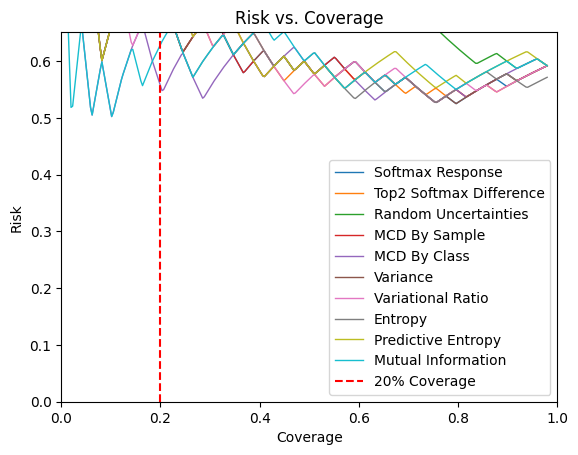


NV: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Predictive Entropy          	0.2097			0.3032
Variance                    	0.2160			0.3082
MCD By Class                	0.2177			0.3134
Softmax Response            	0.2183			0.3196
MCD By Sample               	0.2197			0.3219
Top2 Softmax Difference     	0.2205			0.3232
Variational Ratio           	0.2238			0.3284
Entropy                     	0.2247			0.3344
Mutual Information          	0.2420			0.3376
Random Uncertainties        	0.3658			0.4514


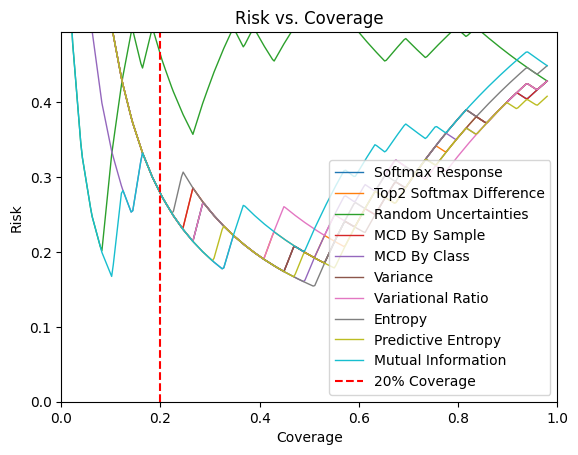


SCC: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Mutual Information          	0.4324			0.5574
Random Uncertainties        	0.4393			0.6026
MCD By Class                	0.5004			0.6777
MCD By Sample               	0.5291			0.7270
Predictive Entropy          	0.5333			0.7332
Top2 Softmax Difference     	0.5342			0.7336
Variational Ratio           	0.5344			0.7338
Variance                    	0.5352			0.7341
Softmax Response            	0.5361			0.7356
Entropy                     	0.5406			0.7429


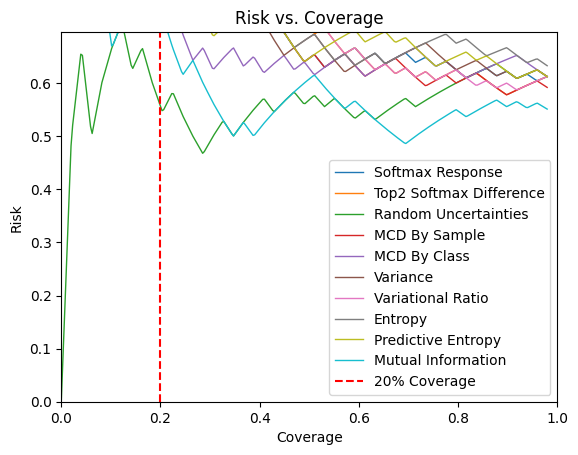


VASC: 49 samples
Label                  	AURC (20% cutoff)	AURC (full)
----------------------------------------------------------
Predictive Entropy          	0.0098			0.0098
Softmax Response            	0.0115			0.0115
MCD By Sample               	0.0115			0.0115
Variance                    	0.0115			0.0115
Top2 Softmax Difference     	0.0124			0.0124
Variational Ratio           	0.0130			0.0130
MCD By Class                	0.0131			0.0131
Entropy                     	0.0143			0.0143
Mutual Information          	0.0152			0.0152
Random Uncertainties        	0.0968			0.0997


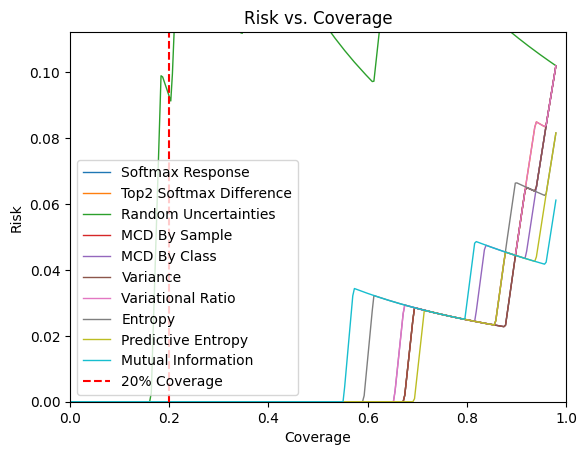


done


In [32]:
print(f"All Classes: {len(risks_list[0])} samples")
x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list[0])
calculate_aurc(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)
# Plot the risk coverage curve
plot_risk_coverage(risks_list, labels_list, x_smooth_percentage_interp, x_smooth_percentage)

for i in range(len(class_names)):
    print(f"{class_names[i]}: {len(risks_list_by_class[i][0])} samples")
    x_smooth_percentage_interp, x_smooth_percentage = smooth_calcs(risks_list_by_class[i][0])
    calculate_aurc(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    # Plot the risk coverage curve
    plot_risk_coverage(risks_list_by_class[i], labels_list_by_class[i], x_smooth_percentage_interp, x_smooth_percentage)
    print()
    
print("done")